In [2]:
import pandas as pd
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from scipy import linalg
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline

Using TensorFlow backend.


In [3]:
np.random.seed = 121

In [4]:
def generate_signal(N=101): #generate sinal  - triangles 
    
    width1  = np.random.uniform(0.1, 0.2)
    center1 = np.random.uniform(width1, 0.5 - width1)
    height1 = np.random.uniform(-2, 2)

    width2 = np.random.uniform(0.1, 0.2)
    center2 = np.random.uniform(0.5 + width2, 0.5 - width2)
    height2 = np.random.uniform(-2, 2)
    signal = np.zeros(N)
    dt = 1.0/(N - 1)
    for i in range(N):
        t = i*dt
        if t > center2 + width2:
            signal[i] = 0.0
        elif t > center2:
            signal[i] = height2*(center2 + width2 - t)/width2
        elif t > center2 - width2:
                signal[i] = height2*(t - center2 + width2)/width2
        elif t > center1 + width1:
                signal[i] = 0.0
        elif t > center1:
                signal[i] = height1*(center1 + width1 - t)/width1
        elif t > center1 - width1:
                signal[i] = height1*(t - center1 + width1)/width1
        elif t > 0:
            signal[i] = 0.0
            
    return signal

In [5]:
#test signal = f0
def test_signal(x):
    if x > 0.7:
        return 0.0
    elif x > 0.6:
        return (0.7 - x)/0.1
    elif x > 0.5:
        return (x - 0.5)/0.1  
    elif x > 0.4:
        return (0.5 - x)/0.1  
    elif x > 0.3:
        return (x - 0.3)/0.1
    else:
        return 0.0

In [6]:
def generate_smoothing_matrix(size_in, size_out, half_width): #A - матрица размытия, характеризующая прибор измерения
    m = np.zeros([size_out, size_in])
    width = 2.0*half_width
    value = 1.0 / width
    # value = 1.0
    for i in range(size_out):
        m[i, i] = value
        for j in range(0, half_width):
            index_right = i + j + 1
            index_left = i - j - 1
            if index_right < size_out:
                m[i, index_right] = value
            if index_left >= 0:
                m[i, index_left] = value
    return m

In [28]:
def generate_correlated_vector(sqrt_covariance_operator): #генерация матрицы ковариации
    return np.matmul(sqrt_covariance_operator, np.random.normal(0, 1, np.size(sqrt_covariance_operator, 0))) #в нашем случае компоненты не скореллированы

In [29]:
# generate test signal
#f0
N = 101 
halfWidth = 10
#sigma = 1.0
A = generate_smoothing_matrix(N, N, halfWidth)
t = np.arange(0, 1.0 + 1.e-10, 1.0/(N - 1))
f0 = np.zeros(N)

for i in range(N):
    f0[i] = test_signal(t[i])

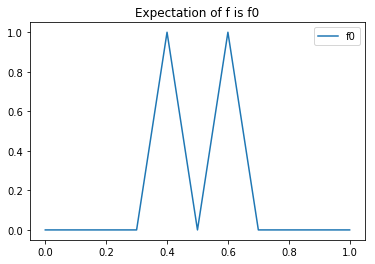

In [30]:
plt.plot(t,f0)
plt.title('Expectation of f is f0')
plt.legend(['f0'])

In [40]:
sqrt_F = 0.1*np.eye(N)
F = np.dot(sqrt_F.T,sqrt_F )

In [41]:
sqrt_Sigma = 0.1*np.eye(N)
Sigma = np.dot(sqrt_Sigma.T,sqrt_Sigma)

In [42]:
#test
f = f0 + generate_correlated_vector(sqrt_F)
nu = generate_correlated_vector(sqrt_Sigma)
smoothed_f = np.dot(A,f)
ksi = np.dot(A,f) + nu

In [43]:
#lin est - аналитическое решение
Sigma_inversed = np.linalg.inv(Sigma)
T = np.dot(np.dot(A.T,Sigma_inversed),A)
v = np.dot(np.dot(A.T, Sigma_inversed),ksi)
T_aprior = np.linalg.inv(F)
v_aprior = np.matmul(T_aprior,f0)

lin_est_f = np.matmul(np.linalg.inv(T + T_aprior),(v + v_aprior))

Нейросеть

In [44]:
#generate training sample
n_train = 10000
f_train = np.zeros([n_train, N])
ksi_train = np.zeros([n_train, N])
for i in range(n_train):
    signal = generate_signal(N)
    temp_f = signal + generate_correlated_vector(sqrt_F)
    f_train[i, :] = temp_f
    ksi_train[i, :] = np.dot(A,temp_f) + generate_correlated_vector(sqrt_Sigma)

In [45]:
model = keras.Sequential([
    keras.layers.Dense(N, activation=tf.nn.relu), 
    keras.layers.Dense(N)
])

In [46]:
model.compile(loss="mse", optimizer="adam")
model.fit(x=ksi_train, y=f_train, batch_size=n_train//100, epochs=80)

f_ANN = model.predict_on_batch(ksi.reshape([1, N]))



Epoch 1/80
10000/10000 [==============================] - 0s 29us/step - loss: 0.0938
Epoch 2/80
10000/10000 [==============================] - 0s 11us/step - loss: 0.0312
Epoch 3/80
10000/10000 [==============================] - 0s 10us/step - loss: 0.0258
Epoch 4/80
10000/10000 [==============================] - 0s 10us/step - loss: 0.0235
Epoch 5/80
10000/10000 [==============================] - 0s 10us/step - loss: 0.0222
Epoch 6/80
10000/10000 [==============================] - 0s 11us/step - loss: 0.0213
Epoch 7/80
10000/10000 [==============================] - 0s 11us/step - loss: 0.0206
Epoch 8/80
10000/10000 [==============================] - 0s 11us/step - loss: 0.0201
Epoch 9/80
10000/10000 [==============================] - 0s 12us/step - loss: 0.0197
Epoch 10/80
10000/10000 [==============================] - 0s 11us/step - loss: 0.0194
Epoch 11/80
10000/10000 [==============================] - 0s 11us/step - loss: 0.0191
Epoch 12/80
10000/10000 [===========================

In [47]:
lin_err = mean_squared_error(f,lin_est_f)
nn_err = mean_squared_error(f_ANN.T, f)
print('MSE for Linear model: %s' %lin_err)
print('MSE for Neural model: %s' %nn_err)

MSE for Linear model: 0.010217917685327073
MSE for Neural model: 0.02208273856092689


Рисуем

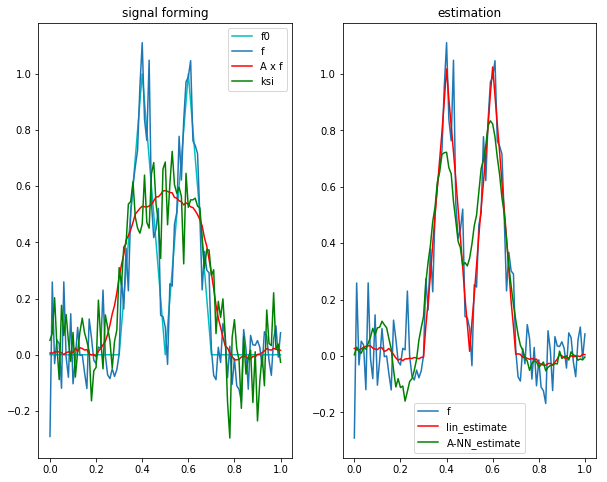

In [48]:
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.plot(t, f0, 'c')
plt.plot(t, f)
plt.plot(t, smoothed_f, 'r')
plt.plot(t, ksi, 'g')
plt.title('signal forming')
plt.legend(['f0', 'f', 'A x f', 'ksi'])
plt.subplot(1, 2, 2)
plt.plot(t, f)
plt.plot(t, lin_est_f.transpose(), 'r')
plt.plot(t, f_ANN.transpose(), 'g')
plt.title('estimation')
plt.legend(['f', 'lin_estimate', 'A-NN_estimate'])
plt.show()